In [1]:
%matplotlib inline 
from IPython.display import display, HTML
import pandas as pd 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import matplotlib as mpl 
import os 
import numpy as np 
import pylab as pl
import scipy.stats as st
import glob 
from ifis_tools import database_tools as db
from ifis_tools import series_tools as ser
import hydroeval as heval
from multiprocessing import Pool
import _pickle as cPickle

In [141]:
#Code aprameters
Prop = pd.read_msgpack('/media/nicolas/Data/RunoffExp/Results/BasinsProperties.msg')
path = '/media/nicolas/Data/RunoffExp/Results/Process/'
TlValues = np.array(['01','009','007','005','003'])

#Color schemes
ColorModels = {'01':'#614B12',
    '009':'#ED7511',
    '007':'#346D0D',
    '005':'#2A5BAC',
    '003':'#C80C2E'}
#Colores eficiencia
coloresEF = ['#0A369C','#508DBA','#88AECA','#C9D8E3','#FCFDFE','#F3D9D5','#EEACA2','#E86653','#AA2714']

coloresRa = ['#0A369C','#508DBA','#88AECA','#C9D8E3','#a081ef','#F3D9D5','#EEACA2','#E86653','#AA2714']


# Overall RC analysis 

In [364]:
#Void dictionaries with all the RC values
RcObs = {}
RcSim = {}
for tl in TlValues:
    RcObs.update({tl:[]})
    RcSim.update({tl:[]})
RainAll = []
#Read the data for links with an area below a treshold
for link in Prop['area'][Prop['area']<2500].index:
    try:
        #Read the distribution of RC p50 to determine the best
        Qobs, Qsim, Events = ReadPickle('/media/nicolas/Data/RunoffExp/Results/Process/RC_'+link+'.bin')
        #Obtains the simulated and observed runoff.        
        ro = Qobs[link]['RC']
        rain = Qobs[link]['Rain']
        for tl in TlValues:
            rs = Qsim[link][tl]['RC']
            inde = ro.index.intersection(rs.index)
            RainGood = rain[inde]
            pos = np.where(RainGood<500)[0]
            RcObs[tl].extend(ro[inde].values[pos])
            RcSim[tl].extend(rs[inde].values[pos])
    except:
        pass

#Convert to numpy
for tl in TlValues:
    RcObs[tl] = np.array(RcObs[tl])
    RcSim[tl] = np.array(RcSim[tl])
    

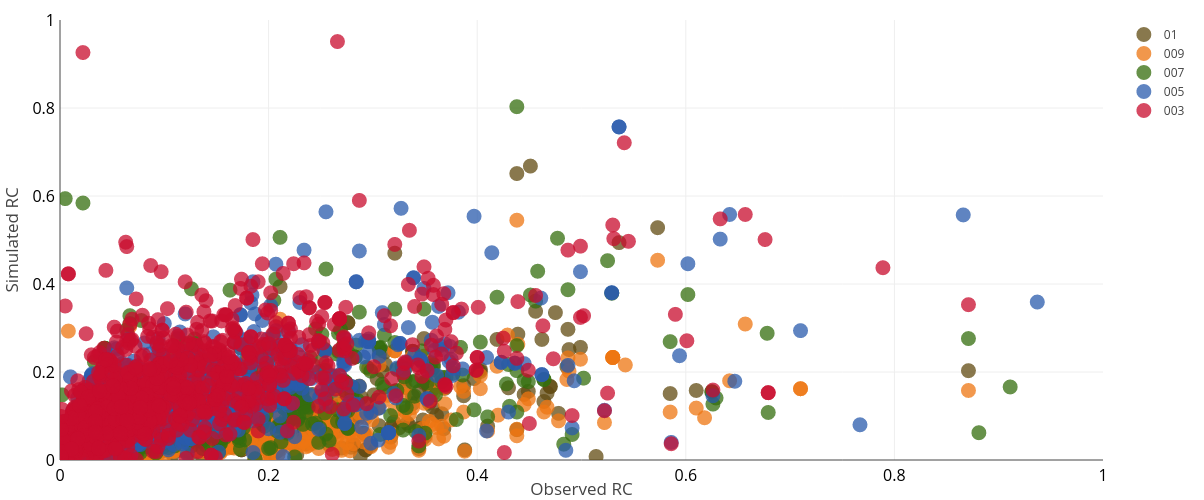

In [365]:
#Scatter Overall analysis
ObsList = []
SimList = []
Texto = []
Nombres = []
Color = []
Alpha = []

pos = np.random.choice(RcObs[tl].size, 1000)
for tl,op in zip(TlValues, [0.75,0.75,0.75,0.75,0.75]):
    ObsList.append(np.around(RcObs[tl][pos], 3))
    SimList.append(np.around(RcSim[tl][pos], 3))
    Texto.append(tl)
    Nombres.append(tl)
    Color.append(ColorModels[tl])
    Alpha.append(op)

div, fig = Scatter(ObsList, SimList, multiple=True,
    Color = Color, Texto = Texto, Nombres = Nombres,opacity = Alpha,
    width=600, height=500, rangoX=[0,1], rangoY=[0,1], 
    xLabel = 'Observed RC', yLabel = 'Simulated RC',
    )

In [366]:
ObsList = []
SimList = []
Texto = []
Nombres = []
Color = []
Alpha = []

for tl,op in zip(TlValues, [0.75,0.75,0.75,0.75,0.75]):
    ObsList.append(np.around(RcObs[tl], 3))
    SimList.append(np.around(RcSim[tl], 3))
    Texto.append(tl)
    Nombres.append(tl)
    Color.append(ColorModels[tl])
    Alpha.append(op)
 

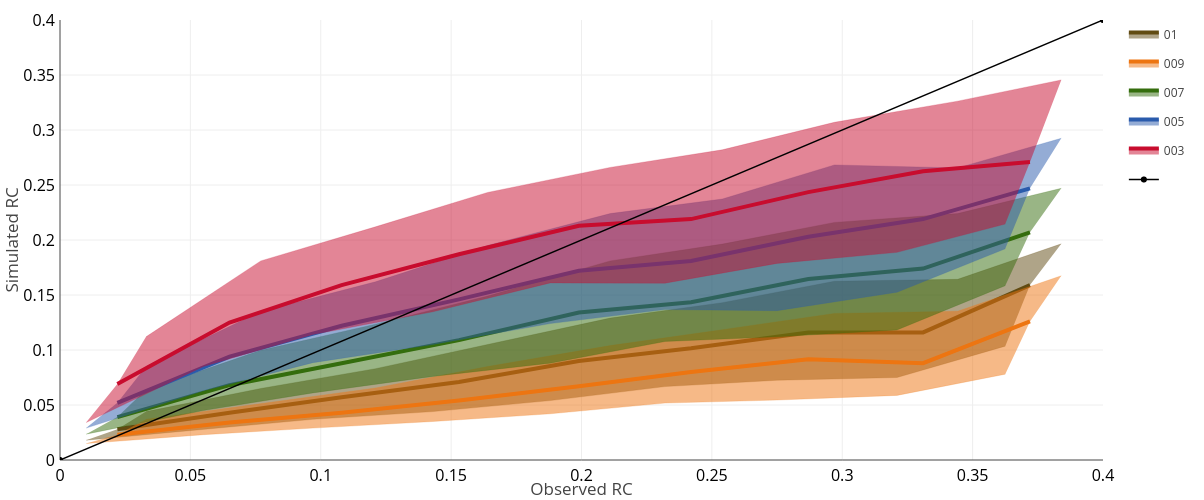

In [367]:
div, fig = Dispersion(ObsList, SimList, np.linspace(0,0.4,10), Percent=[25,50,75],
    Color = Color, Texto = Texto, Nombres = Nombres,
    width=600, height=500, rangoX=[0,0.4], rangoY=[0,0.4], 
    xLabel = 'Observed RC', yLabel = 'Simulated RC',
    )

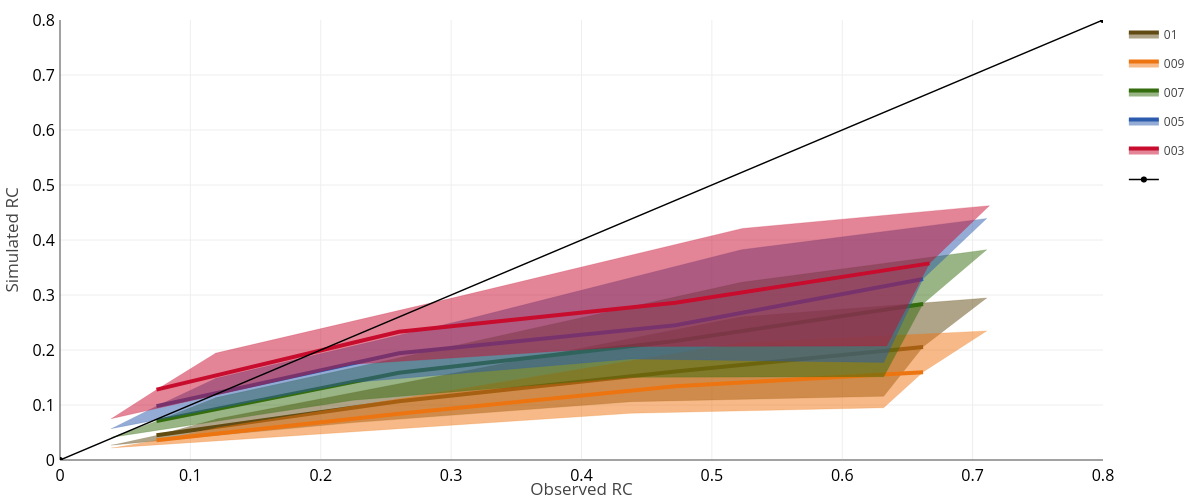

In [368]:
div, fig = Dispersion(ObsList, SimList, np.linspace(0,0.8,5), Percent=[25,50,75],
    Color = Color, Texto = Texto, Nombres = Nombres,
    width=600, height=500, rangoX=[0,0.8], rangoY=[0,0.8], 
    xLabel = 'Observed RC', yLabel = 'Simulated RC',
    )

## Lest see how is the RC vs Qmax

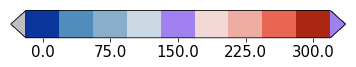

In [358]:
### Void dictionaries with all the RC values
Qmax = []
Rc = []
Rain = []

QmaxS = []
RcS = []

#Read the data for links with an area below a treshold
for link in Prop['area'][(Prop['area']>1000) & (Prop['area']<2000)].index:
    try:
        #Read the distribution of RC p50 to determine the best
        Qobs, Qsim, Events = ReadPickle('/media/nicolas/Data/RunoffExp/Results/Process/RC_'+link+'.bin')
        Qm = []; r = []; rain = []
        QmS = []; rs = []
        for p1, p2 in zip(Events[link]['p1'],Events[link]['p2']):            
            try:
                if Qobs[link]['Rain'][p1]<300:
                    Qm.append(Qobs[link]['Q'][p1:p2].max())
                    r.append(Qobs[link]['RC'][p1])
                    rain.append(Qobs[link]['Rain'][p1])
                    
                    QmS.append(Qsim[link]['005']['Q'][p1:p2].max())
                    rs.append(Qsim[link]['005']['RC'][p1:p2].max())
            except:
                pass
        Qmax.extend(Qm)
        Rc.extend(r)
        Rain.extend(rain)
        
        QmaxS.extend(QmS)
        RcS.extend(rs)
    except:
        pass
Qmax = np.array(Qmax)
Rc = np.array(Rc)
Rain = np.array(Rain)
RcS = np.array(RcS)
QmaxS = np.array(QmaxS)

ColoresRain = Remuestreador(Rain, np.linspace(0,300,9), coloresRa)
texto = np.array(['Peak: %.1f Rain: %.1f'%(i,j) for i,j in zip(Qmax, Rain)])
CreateColorbar(coloresRa, np.linspace(0,300,9), '/home/nicolas/Desktop/RainfallColorbar.png')

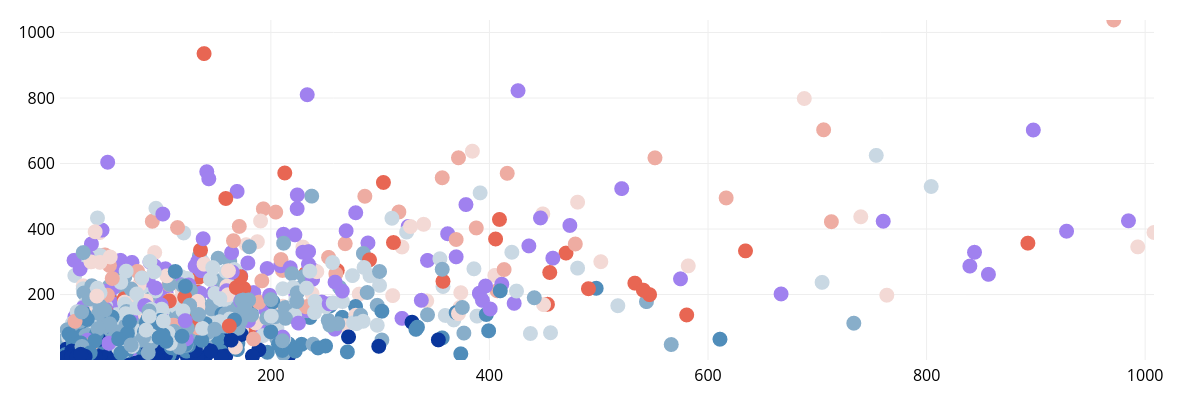

In [359]:
div,fig = Scatter(Qmax, QmaxS, width=500, height=400, Color = ColoresRain)

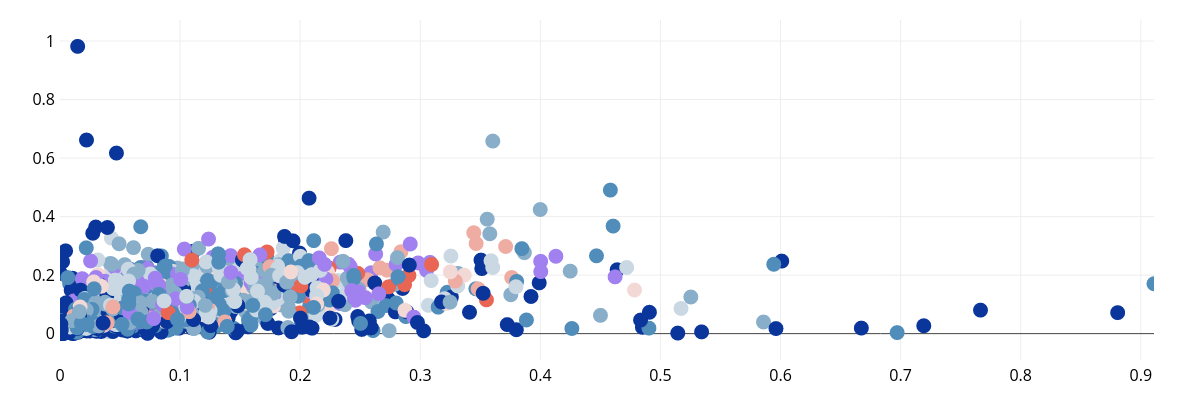

In [360]:
div,fig = Scatter(Rc, RcS, width=500, height=400, Color=ColoresRain)

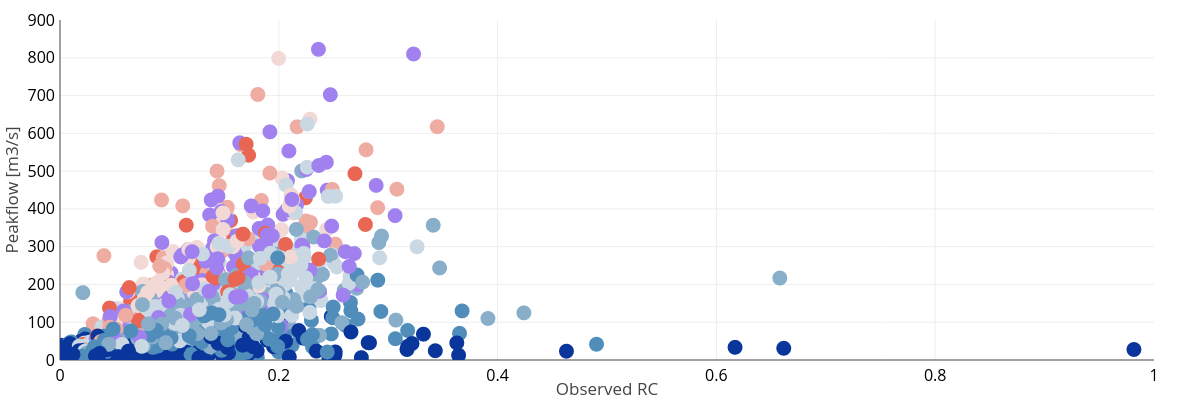

In [361]:
div, fig = Scatter(RcS, QmaxS, width=500, height=400, 
    Color=ColoresRain, xLabel='Observed RC', yLabel = 'Peakflow [m3/s]', Texto = texto, 
    rangoX=[0,1], rangoY = [0,900])

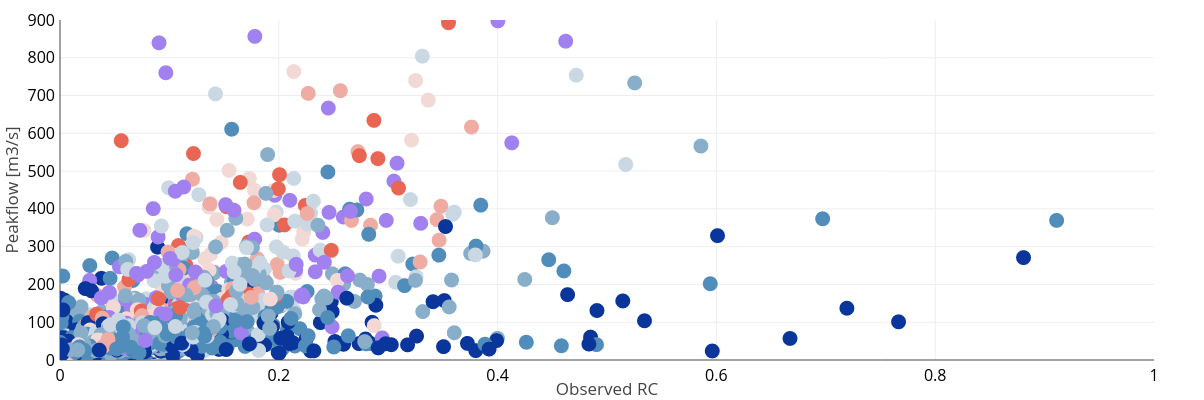

In [362]:
div, fig = Scatter(Rc, Qmax, width=500, height=400, 
    Color=ColoresRain, xLabel='Observed RC', yLabel = 'Peakflow [m3/s]', Texto = texto, 
    rangoX=[0,1], rangoY = [0,900])

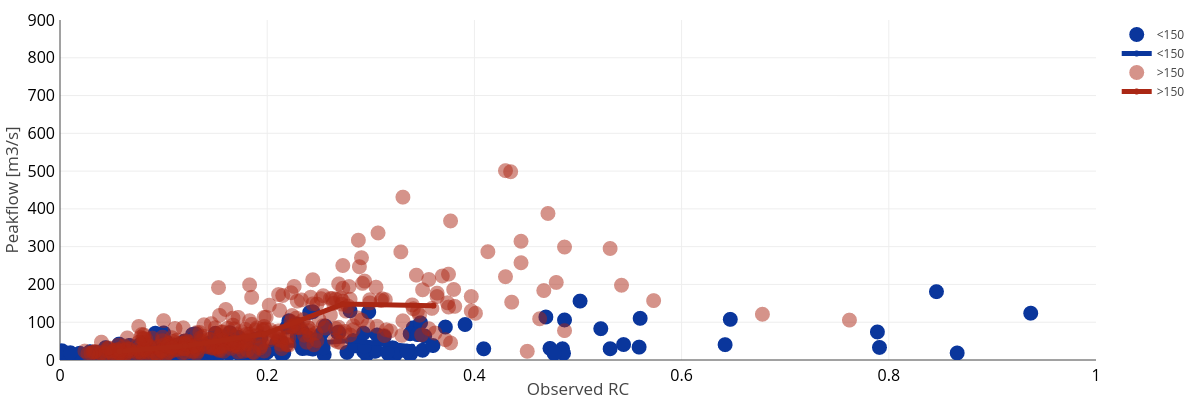

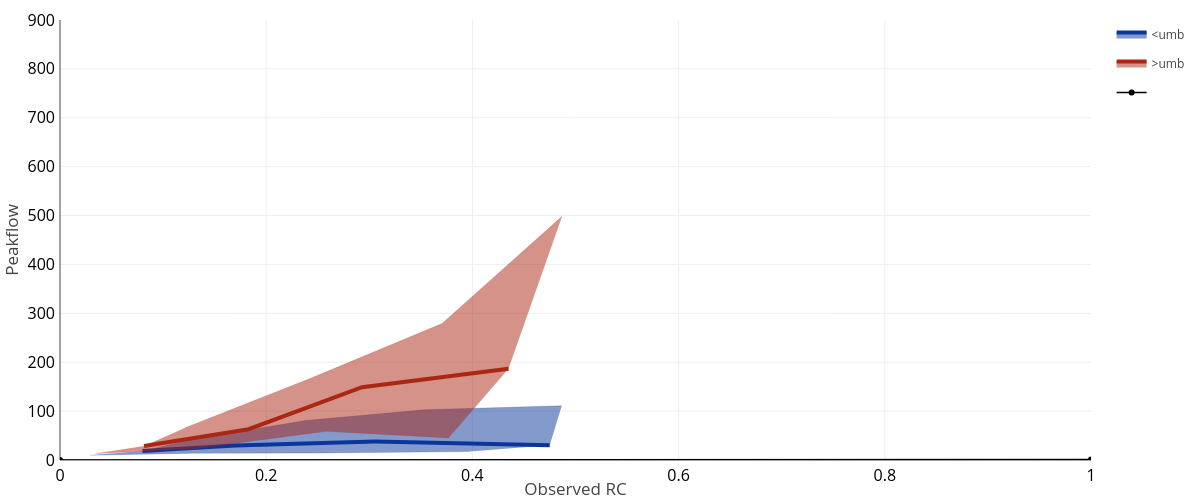

In [276]:
Qmax = np.around(Qmax, 1)
Rc = np.around(Rc, 3)
umb = 85
RcG = [Rc[Rain<umb], Rc[Rain>=umb]]
QmaxG = [Qmax[Rain<umb], Qmax[Rain>=umb]]
Color = [coloresRa[0], coloresRa[-1]]
Texto = [texto[Rain<umb], texto[Rain>=umb]]

div, fig = Scatter(RcG, QmaxG, width=500, height=400, multiple=True, opacity=[1,0.5], Nombres=['<150','>150'],
    bins = np.linspace(0,0.4,6), trend = True,
    Color=Color, xLabel='Observed RC', yLabel = 'Peakflow [m3/s]', Texto = Texto, 
    rangoX=[0,1], rangoY = [0,900])

div, fig = Dispersion(RcG, QmaxG, np.linspace(0,0.5,5), Percent=[5,50,95],
    Color = Color, Texto = Texto, Nombres = ['<umb','>umb'],
    width=600, height=500, rangoX=[0,1], rangoY = [0,900], 
    xLabel = 'Observed RC', yLabel = 'Peakflow',
    )


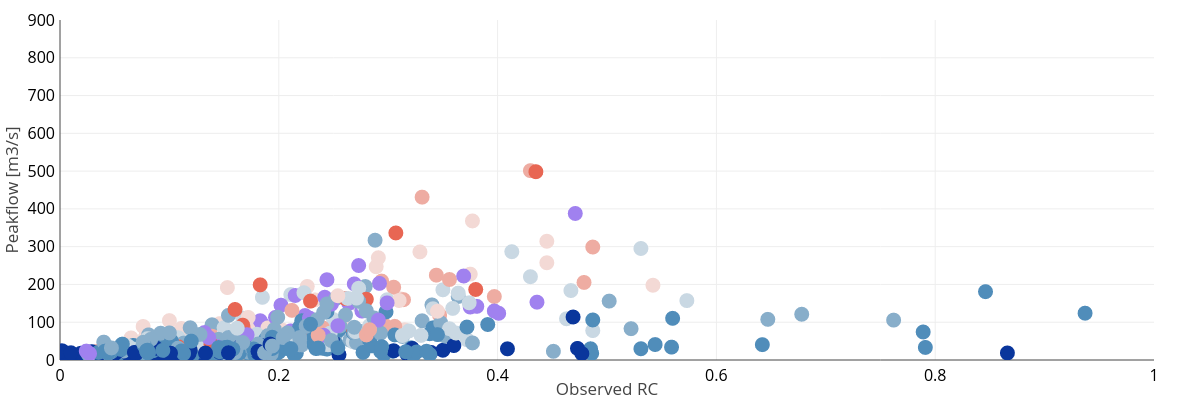

In [8]:


TlVal = []
TlCount = []
Consistency = []

Lat = []
Lon = []
LinkId = []

MatP50 = []
MatP50model = []

for link in Prop['area'][Prop['area']<2500].index:
    try:
        #Read the distribution of RC p50 to determine the best
        Qobs, Qsim, Events = ReadPickle('/media/nicolas/Data/RunoffExp/Results/Process/RC_'+link+'.bin')
        RcMat = []
        for k in TlValues:
            RcMat.append(Qsim[link][k]['RC_qual'])
        RcMat = np.array(RcMat)

        #Determine the value of the best and the model that corresponds
        RcBest = RcMat.min(axis = 0)
        RcBestPos = RcMat.argmin(axis = 0)
        
        MatP50.append(RcBest.tolist())
        MatP50model.append(TlValues[RcBestPos])
        
        #Calculte the consistency, mode and best model
        Consistency.append(np.abs(np.diff(RcBestPos)).sum())
        Mode = st.mode(RcBestPos)
        TlVal.append(TlValues[Mode.mode[0]])
        TlCount.append(Mode.count[0])
        
        #Coord and link ID
        Lat.append(Prop['coord'][link][0])
        Lon.append(Prop['coord'][link][1])
        LinkId.append(link)
    except:
        pass
MatP50 = np.array(MatP50).T
MatP50model = np.array(MatP50model).T

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning:

invalid value encountered in reduce



In [27]:
rs.index.intersection(ro.index).size

54

# Functions

In [166]:
def Percent_by_interval(Data, DataB, per=50, bins = np.linspace(0,1,5)):
    Percent = []
    for b1, b2 in zip(bins[:-1], bins[1:]):
        Percent.append(np.percentile(Data[(DataB>b1) & (DataB<=b2)], per))
    return Percent

def CreateColorbar(colorList,ticks,path,jump=2, label = ''):
    fig, ax = pl.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cmap = mpl.colors.ListedColormap(colorList)
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = np.arange(1,len(colorList)+2).tolist()#[1, 2, 3, 4,5,6]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries=[0] + bounds + [1],
                                    extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label(label, size = 16)
    cb2.set_ticks(np.arange(1.5,len(colorList)+2.5).tolist()[::jump])
    cb2.ax.set_xticklabels(ticks[::jump], size = 15)
    fig.show()
    pl.savefig(path, bbox_inches = 'tight')

def Dispersion(X, Y, bins, Percent = [25,50,75],Color = 'blue',
    xLabel = '', yLabel = '', width = 300, height = 250,
    Xtype='', Ytype='', rangoX = None, rangoY = None, Texto = None, Nombres = None):
    
    data = []
    for x1,y1,c,t,n in zip(X,Y,Color,Texto, Nombres):
        for per,fil,w,legend in zip(Percent, [None, 'tonexty', 'tonexty'], [0.2,4,0.2],[False, True, False]):
            trace = go.Scatter(
                x = Percent_by_interval(x1,x1, per, bins = bins),
                y = Percent_by_interval(y1,x1, per, bins = bins),
                name = n,
                legendgroup=n,
                showlegend = legend,
                fill = fil,
                mode = 'lines',
                line = dict(
                    color = c,
                    width = w,
                )
            )
            data.append(trace)
    if rangoX is None: rangoX = [np.min(X), np.max(X)]
    if rangoY is None: rangoY = [np.min(Y), np.max(Y)]
    
    trace = go.Scatter(
        x = rangoX,
        y = rangoX,
        name = '',
        line = dict(
            color = 'black',
            width = 1.5
        )
    )
    data.append(trace)
        
    layout = go.Layout(
        width=width,
        height=height,    
        yaxis=dict(
            title=yLabel,
            type = Ytype,
            range = rangoY,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = xLabel,
            type = Xtype,
            range = rangoX,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
            ),),
        margin=dict(
            l=60,
            r=50,
            b=40,
            t=20,
            pad=4
        ),
    )
    config={'showLink': False}
    fig = go.Figure(data=data,layout=layout)
    iplot(fig, config = config)
    div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig
    
def PlotMap(data, updatemenus, imageDict = []):
    mapbox_access_token = 'pk.eyJ1Ijoibmljb2xhczk5OCIsImEiOiJjanNvcm02OHMwcHhhNDltcDk0Yzhlc2NkIn0.BoQ8-blC4FoYJQr0wMHVmQ'
    layout = go.Layout(
        width=850,
        height=650,    
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=42.,
                lon=-93.6
            ),
            # we want the map to be "parallel" to our screen, with no angle
            pitch = 0,
            # default level of zoom
            zoom = 6.2,
            # default map style
            style = 'light'
        ),
       margin=dict(
        l=60,
        r=50,
        b=40,
        t=20,
        pad=4
        ),
       images= imageDict,
    )
    layout['updatemenus'] = updatemenus

    fig = dict(data=data, layout=layout)

    iplot(fig, filename='Montreal Mapbox')
    div = plot(fig, include_plotlyjs=False, output_type='div')
    return div 

def ReadPickle(path):
    f = open(path, 'rb')
    Qobs = cPickle.load(f)
    Qsim = cPickle.load(f)
    Events = cPickle.load(f)
    f.close()
    return Qobs, Qsim, Events

def Scatter(X, Y, Color = 'blue', multiple = False,size = 15,
    xLabel = '', yLabel = '', width = 300, height = 250,
    Xtype='', Ytype='', rangoX = None, rangoY = None, Texto = None, Nombres = None,
    opacity = 0.75, trend = False, bins = None):
    data = []
    if multiple:
        for x1,y1,c,t,n,op in zip(X,Y,Color,Texto, Nombres, opacity):
            #Scatter RCobs Vs RCmodel
            trace = go.Scatter(
                x = x1,
                y = y1,
                mode = 'markers',
                name = n,
                text = t,
                marker = dict(
                    color = c,
                    size = size,
                    opacity = op
                    ),
                )
            data.append(trace)
            if trend:
                trace = go.Scatter(
                    x = Percent_by_interval(x1,x1, 50, bins = bins),
                    y = Percent_by_interval(y1,x1, 50, bins = bins),
                    name = n,
                    line = dict(
                        color = c,
                        width = 5,
                    )
                )
                data.append(trace)
    else:        
        #Scatter RCobs Vs RCmodel
        trace = go.Scatter(
            x = X,
            y = Y,
            mode = 'markers',
            name = 'name',
            text = Texto,
            marker = dict(
                color = Color,
                size = size,
                ),
            )
        data.append(trace)
    if rangoX is None: rangoX = [np.min(X), np.max(X)]
    if rangoY is None: rangoY = [np.min(Y), np.max(Y)]
        
    layout = go.Layout(
        width=width,
        height=height,    
        yaxis=dict(
            title=yLabel,
            type = Ytype,
            range = rangoY,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = xLabel,
            type = Xtype,
            range = rangoX,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
            ),),
        margin=dict(
            l=60,
            r=50,
            b=40,
            t=20,
            pad=4
        ),
    )
    config={'showLink': False}
    fig = go.Figure(data=data,layout=layout)
    iplot(fig, config = config)
    div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

def Remuestreador(Data, rango, val2change):
    NewData = []
    for k in Data:
        for b1, b2, c in zip(rango[:-1], rango[1:], val2change):
            if k >= b1 and k <= b2:
                NewData.append(c)
    return np.array(NewData)